In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('bank-additional.csv', sep=';')

# 1. Data Cleaning

## dataset overview

In [35]:
# 1. Dataset Shape (Full dataset)
print("Dataset shape:", df.shape)

# 2. Missing Values per Column
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# 3. Descriptive Statistics
# Display only the first few rows of the descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# 4. Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Variables:")
print(categorical_cols)

# 5. Numerical Variables
numerical_cols = df.select_dtypes(include=['number']).columns
print("\nNumerical Variables:")
print(numerical_cols)

print("Total duplicates:")
print(df.duplicated().sum())

print("Target distribution:")
print(df['y'].value_counts())

Dataset shape: (4119, 21)

Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Descriptive Statistics:
               age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000

## inconsistency check

In [36]:
# Check for inconsistencies in unique values for each column
for col in df.columns:
    unique_vals = df[col].unique()
    if len(unique_vals) < 10:  # Display unique values only for columns with less than 10 unique values
        print(f"\nUnique values for column '{col}':")
        print(unique_vals)
    else:
        print(f"\nColumn '{col}' has {len(unique_vals)} unique values (too many to display).")

    # Example inconsistency check (you might need to adjust this based on your data):
    if col == 'job':  # Example column to check, replace 'job' as needed
        if 'unknown' in unique_vals:
            print("Inconsistency found: 'unknown' value present in 'job' column.")




Column 'age' has 67 unique values (too many to display).

Column 'job' has 12 unique values (too many to display).
Inconsistency found: 'unknown' value present in 'job' column.

Unique values for column 'marital':
['married' 'single' 'divorced' 'unknown']

Unique values for column 'education':
['basic.9y' 'high.school' 'university.degree' 'professional.course'
 'basic.6y' 'basic.4y' 'unknown' 'illiterate']

Unique values for column 'default':
['no' 'unknown' 'yes']

Unique values for column 'housing':
['yes' 'no' 'unknown']

Unique values for column 'loan':
['no' 'unknown' 'yes']

Unique values for column 'contact':
['cellular' 'telephone']

Column 'month' has 10 unique values (too many to display).

Unique values for column 'day_of_week':
['fri' 'wed' 'mon' 'thu' 'tue']

Column 'duration' has 828 unique values (too many to display).

Column 'campaign' has 25 unique values (too many to display).

Column 'pdays' has 21 unique values (too many to display).

Unique values for column 'pre

## handling unknown entries

In [37]:
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    most_common = df[col].mode()[0]
    df[col] = df[col].replace('unknown', most_common)

## handling outliers

# 2. Feature Engineering

In [38]:
df['has_contacted'] = df['pdays'].apply(lambda x: 1 if x != 999 else 0)
df = df.drop(columns=['pdays'])

In [39]:
# ratio to see if the person mostly contacted on the past or now (to see if the campaing fatigue)
df['contact_count_ratio'] = df['previous'] / (df['campaign'] + 1)

In [40]:
# defining categorical and numerical columns after feature engineering
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

## for linear relations of numeric values with target

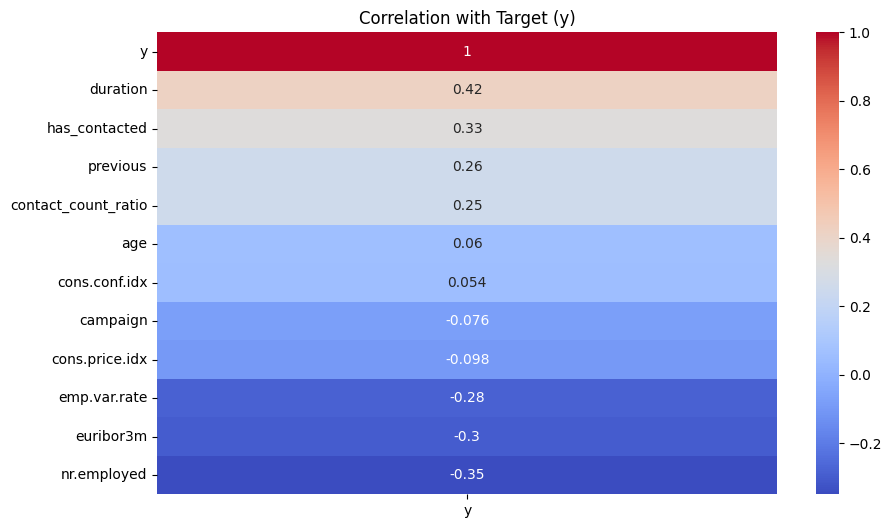

In [41]:
corr_matrix = df[numerical_cols].copy()
corr_matrix['y'] = df['y'].map({'yes': 1, 'no': 0})  # Encode target
corr = corr_matrix.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr[['y']].sort_values(by='y', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Target (y)")
plt.show()

## For nonlinear relationship of features to categorical target

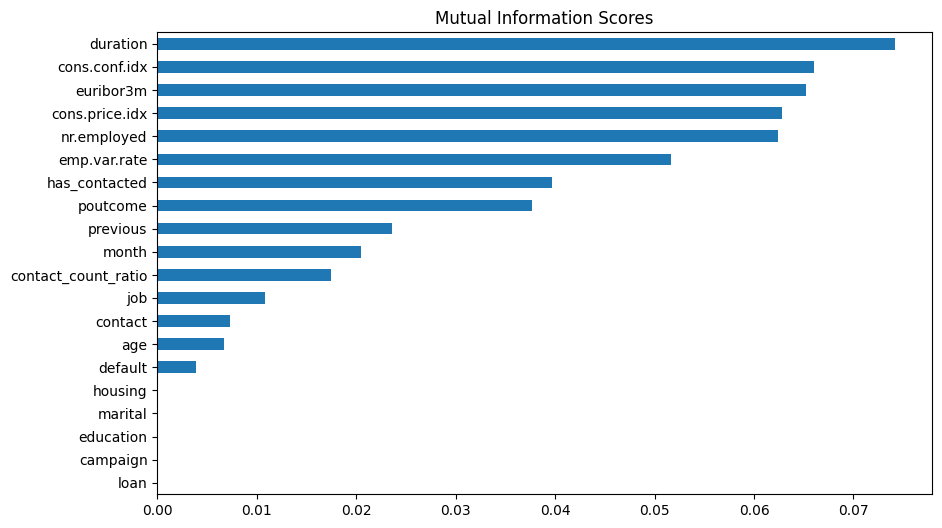

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Encode target
y_encoded = df['y'].map({'yes': 1, 'no': 0})

# For mutual info, use only raw categorical + numerical (before dummies)
X_raw = df.drop('y', axis=1)

# Encode categoricals using LabelEncoder temporarily
X_encoded = X_raw.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y_encoded, discrete_features='auto')
mi_df = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
mi_df.head(20).plot(kind='barh')
plt.title("Mutual Information Scores")
plt.gca().invert_yaxis()
plt.show()

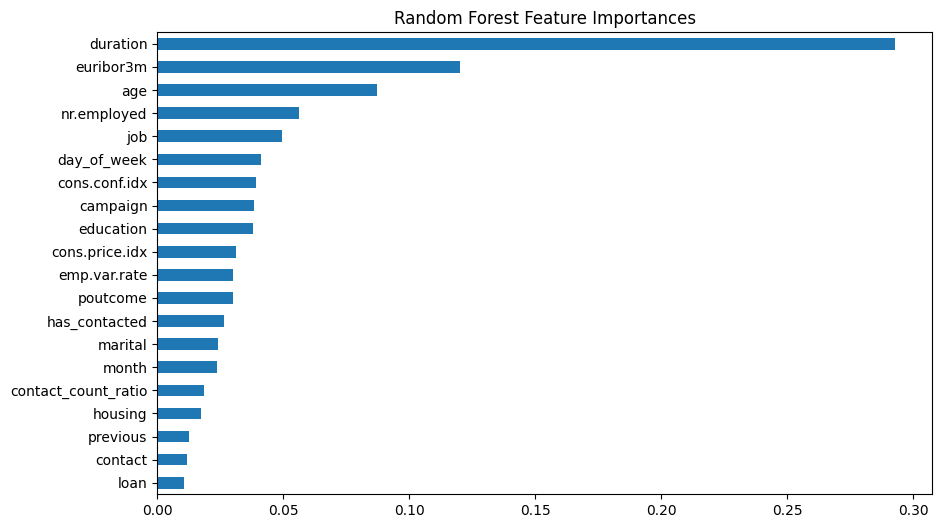

In [43]:
# Again, encode categoricals for modeling
X_rf = X_encoded.copy()
model = RandomForestClassifier(random_state=42)
model.fit(X_rf, y_encoded)

rf_importances = pd.Series(model.feature_importances_, index=X_rf.columns).sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
rf_importances.head(20).plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

## checking pairwise feature relations

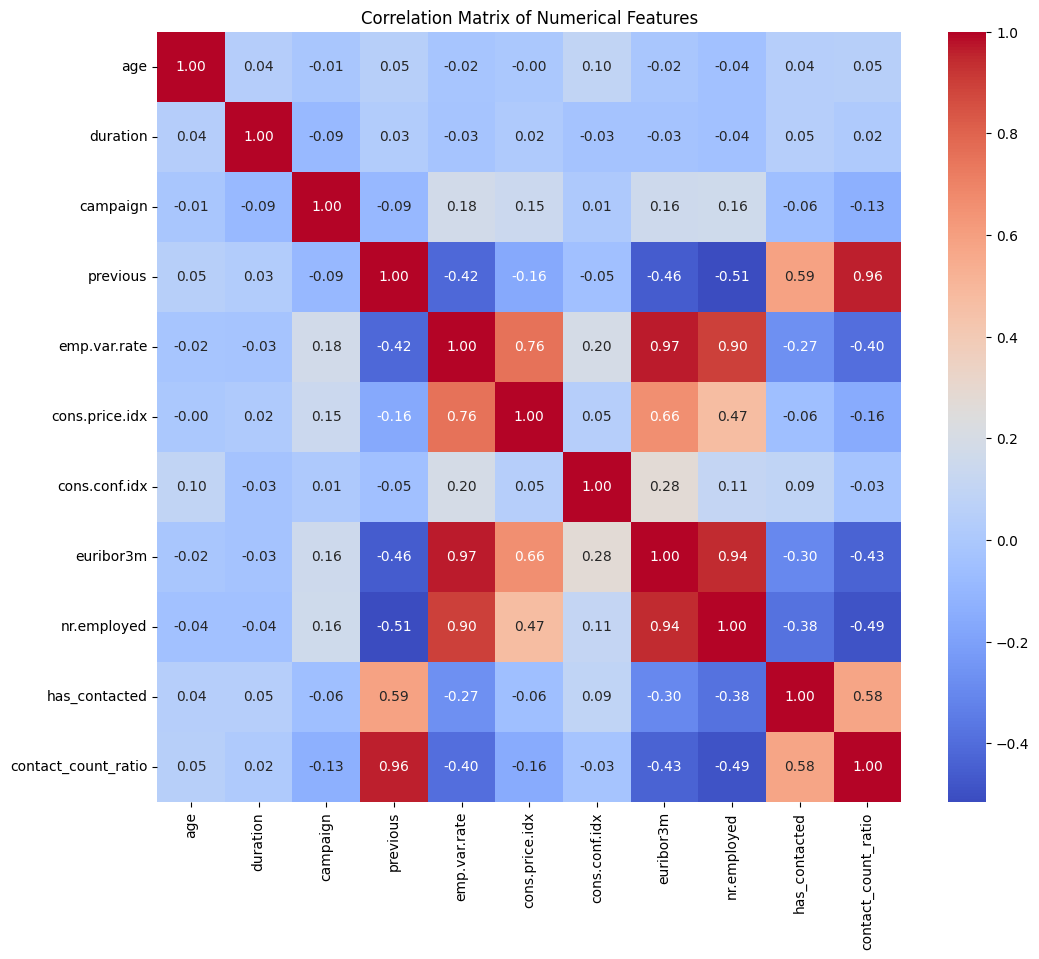

Chi-squared test for job vs marital:
Chi2: 391.41434621575326, p-value: 1.2316496234472513e-70
Chi-squared test for job vs education:
Chi2: 3305.2214139487655, p-value: 0.0
Chi-squared test for job vs default:
Chi2: 36.11687646850347, p-value: 8.037035211346862e-05
Chi-squared test for job vs housing:
Chi2: 12.836856548233788, p-value: 0.23293695692490274
Chi-squared test for job vs loan:
Chi2: 3.8779916545365385, p-value: 0.9526831625303456
Chi-squared test for job vs contact:
Chi2: 66.42811716823181, p-value: 2.158908457668733e-10
Chi-squared test for job vs month:
Chi2: 503.7123473033399, p-value: 8.498089572636172e-59
Chi-squared test for job vs day_of_week:
Chi2: 45.92122537232999, p-value: 0.24020143281698056
Chi-squared test for job vs poutcome:
Chi2: 89.3754691663204, p-value: 9.530125418230339e-11
Chi-squared test for job vs y:
Chi2: 69.65791578872116, p-value: 5.1618326312049e-11
Chi-squared test for marital vs job:
Chi2: 391.4143462157533, p-value: 1.2316496234472163e-70
Chi

poutcome,failure,nonexistent,success
y,,,
no,387,3231,50
yes,67,292,92


In [44]:
# Create a correlation matrix for numerical features
corr_matrix = df[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# For categorical features, you can create contingency tables and chi-squared tests
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-squared test for {col1} vs {col2}:")
            print(f"Chi2: {chi2}, p-value: {p}")
            # You can further analyze the contingency table to understand the relationship
contingency_table



## any feature elimination based on correlations

## histograms and boxplots

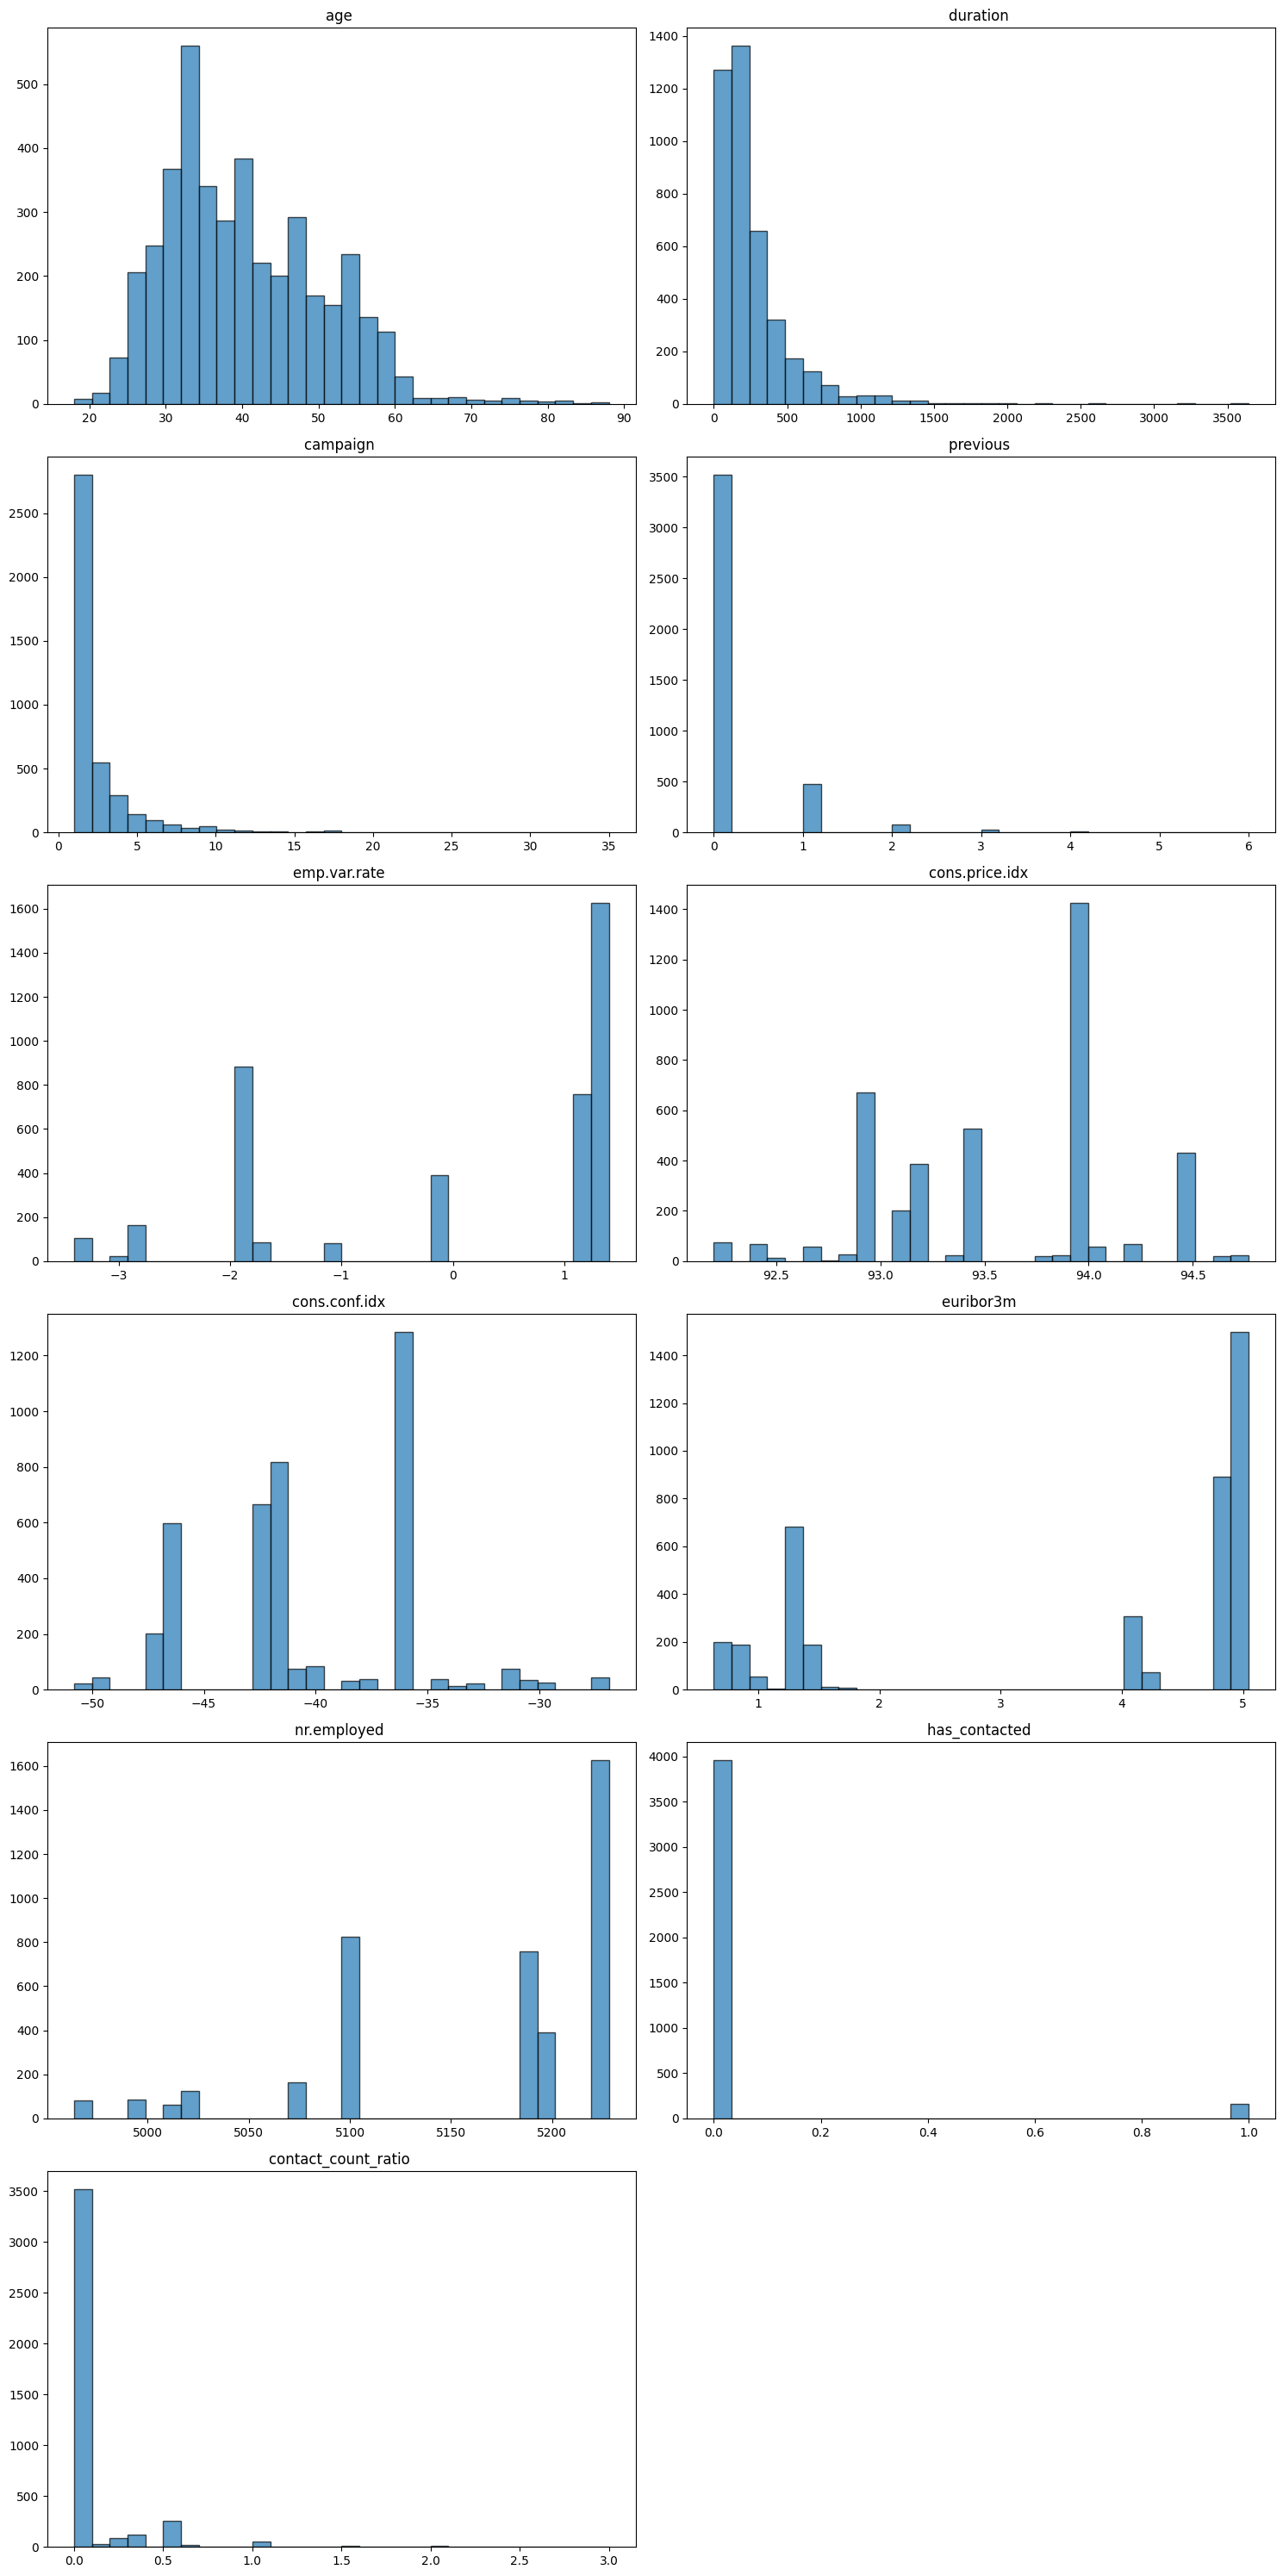

In [45]:
# Determine the number of numerical columns
num_numerical_cols = len(numerical_cols)

# Calculate the grid size (round up to ensure enough space for all subplots)
nrows = (num_numerical_cols // 2) + (num_numerical_cols % 2)
ncols = 2

# Create the subplots with the appropriate size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop over the numerical columns and plot histograms
for i, num in enumerate(numerical_cols):
    axes[i].hist(df[num], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{num} ')

# If there are unused axes, remove them
for i in range(num_numerical_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

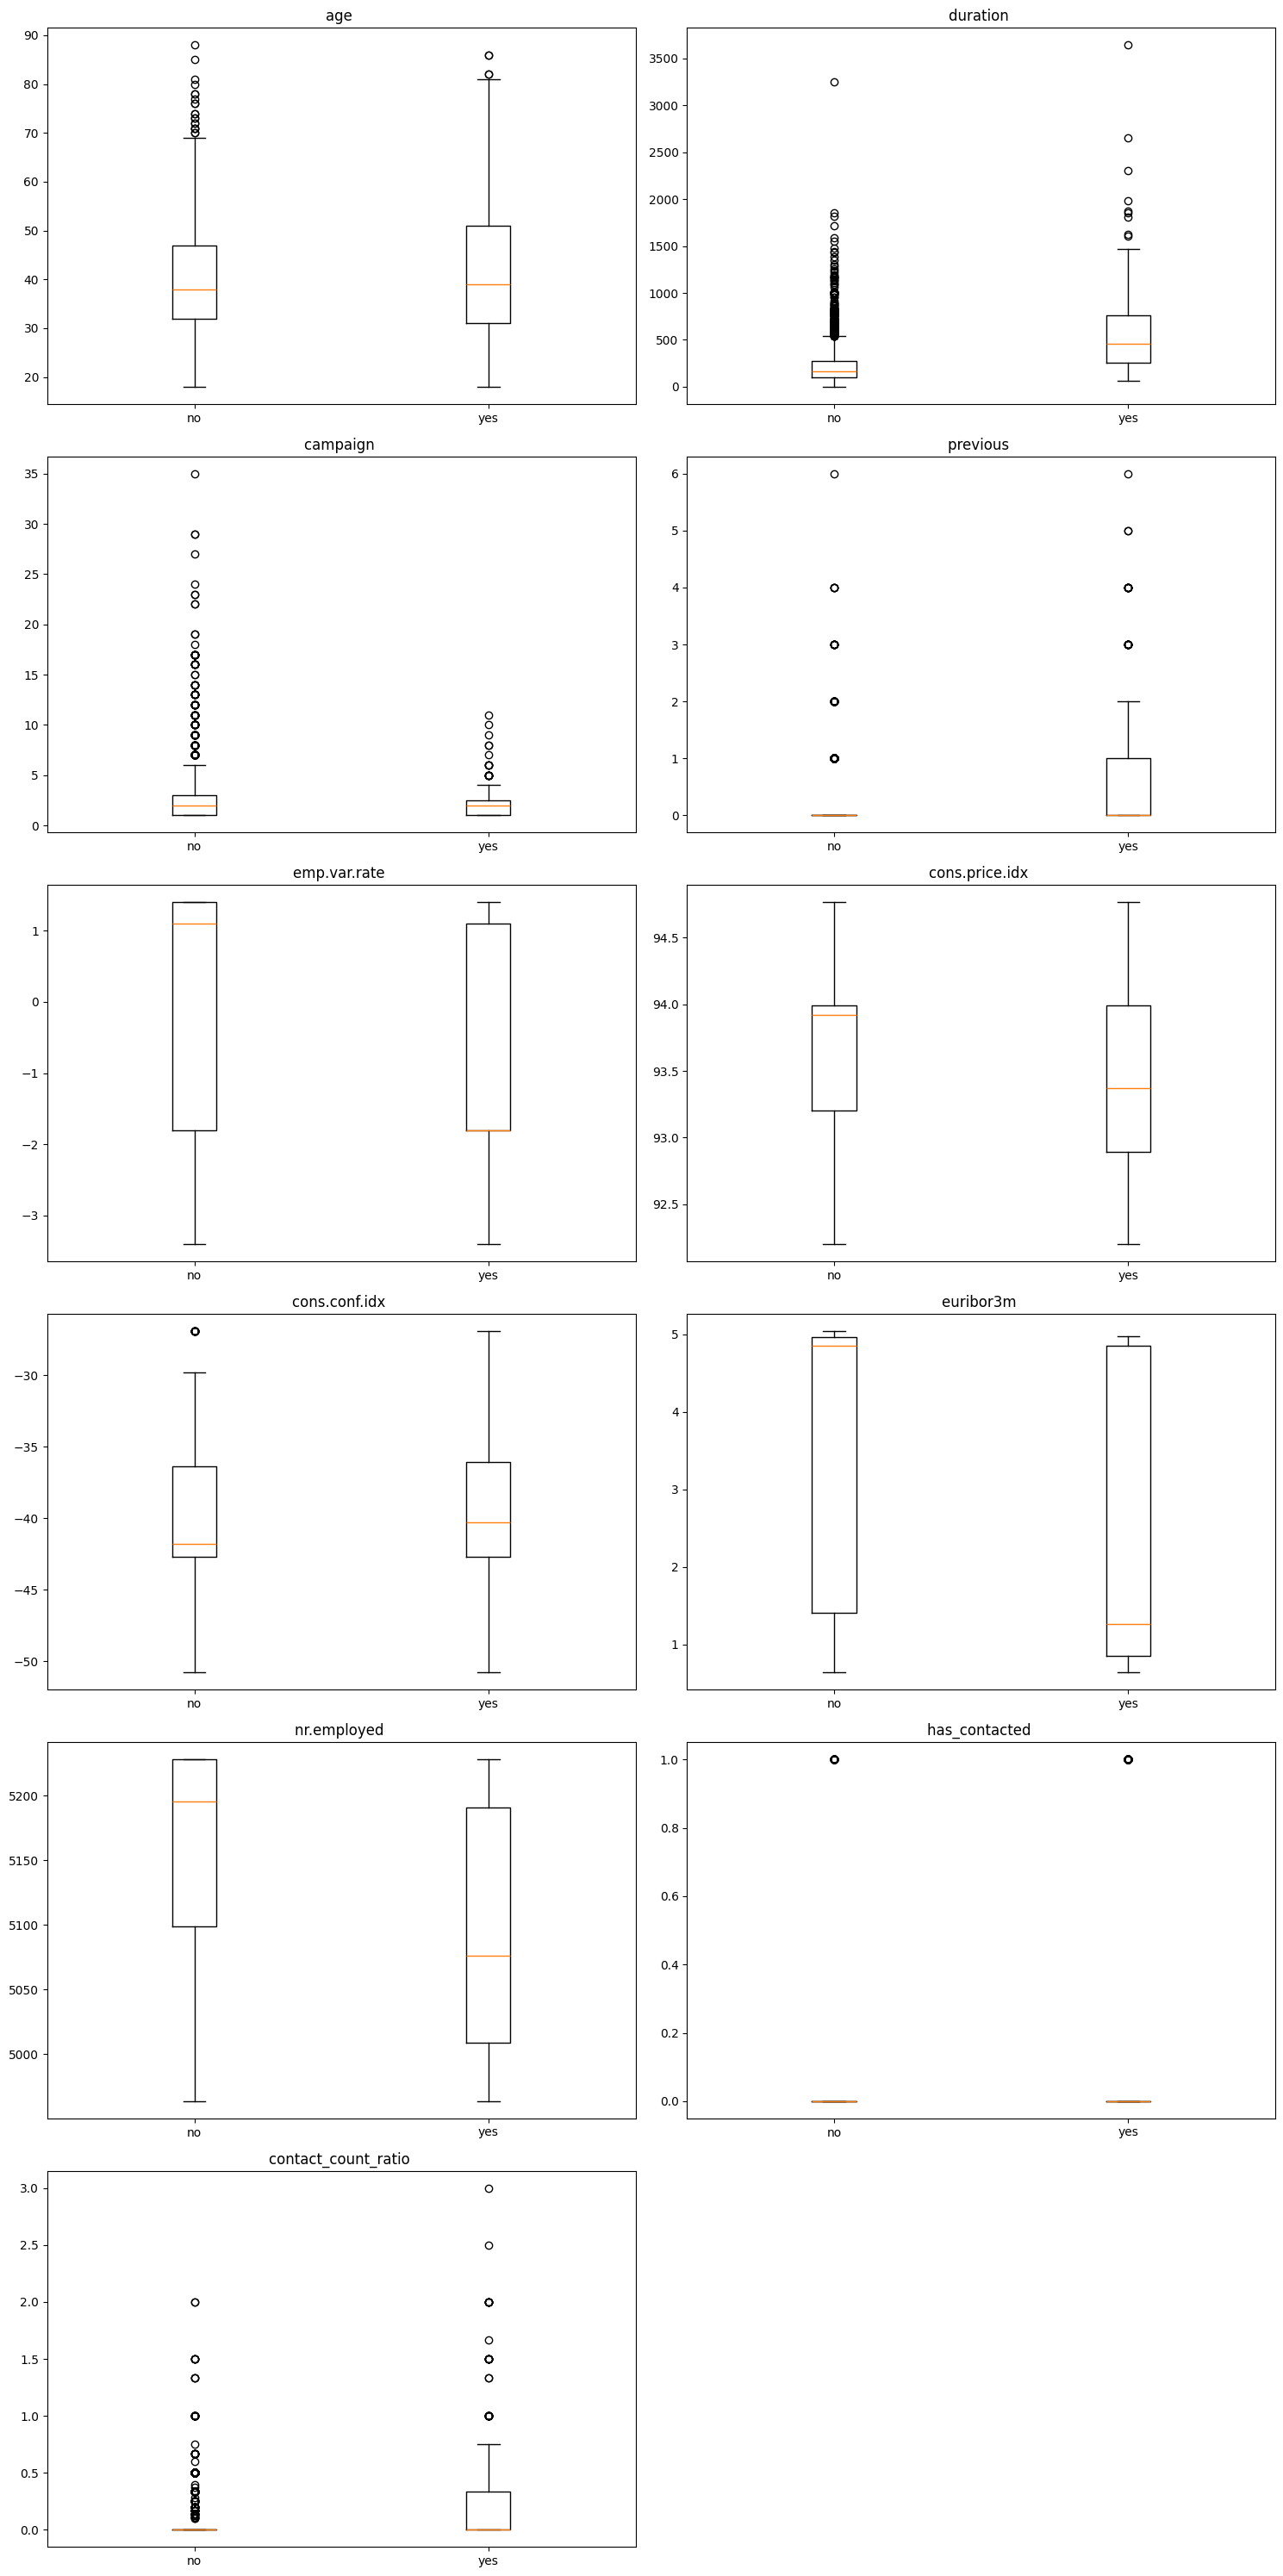

In [46]:
# Create the subplots with the appropriate size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop over the numerical columns and create boxplots
for i, num in enumerate(numerical_cols):
    axes[i].boxplot
    data = [df[df['y'] == value][num] for value in df['y'].unique()]
    axes[i].boxplot(data, labels=df['y'].unique())
    axes[i].set_title(f'{num} ')

# If there are unused axes, remove them
for i in range(num_numerical_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 3. Model selection and Pipelining

In [47]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM (RBF Kernel)': SVC(),             # SVC with default RBF kernel
    'XGBoost': XGBClassifier(),             # XGBoost Classifier
    'LightGBM': LGBMClassifier(),
}

In [48]:
binary_transformer = FunctionTransformer(lambda x: x.applymap(lambda val: 1 if val == 'yes' else 0).astype(int))

ordinal_transformer = OrdinalEncoder(categories=[
    ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
])

nominal_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, ['default', 'housing', 'loan']),
        ('ordinal', ordinal_transformer, ['education']),
        ('nominal', nominal_transformer, ['job', 'marital', 'contact', 'month', 'day_of_week', 'poutcome'])
    ]
)

In [50]:
y = df['y'].map({'yes':1, 'no':0})
X = df.drop(columns=['y'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [52]:
# log transform for right skewed data
X_train[['campaign', 'previous']] = X_train[['campaign', 'previous']].apply(lambda x: np.log1p(x))

## data imbalance check

In [53]:
# Check the class distribution
print(df['y'].value_counts())

y
no     3668
yes     451
Name: count, dtype: int64


In [54]:
# SMOTE to handle imbalance
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)
print(pd.Series(y_train_resampled).value_counts())

y
1    2934
0    2934
Name: count, dtype: int64


## model fit

In [55]:
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Fit the model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Print the model's parameters
    print("Model parameters:")
    print(pipeline.named_steps['classifier'].get_params())

    # Print the model's score
    score = pipeline.score(X_test, y_test)
    print("Model score:", score)



Model: Logistic Regression
Model parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Model score: 0.9029126213592233

Model: Random Forest
Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Model score: 0.8810679611650486

Model: SVM (RBF Kernel)
Model parameters:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_sh

# 4. Hyperparameter Tuning

In [56]:
param_grids = {
    'Logistic Regression': {
        'model__C': [0.1, 1],
        'model__solver': ['liblinear'],
        'model__penalty': ['l2'],
        'model__max_iter': [100]
    },
    'Random Forest': {
        'model__n_estimators': [100],
        'model__max_depth': [10, None],
        'model__min_samples_split': [2, 5],
        'model__max_features': ['sqrt']
    },
    'SVM (RBF Kernel)': {
        'model__C': [1, 10],
        'model__gamma': ['scale'],
        'model__kernel': ['rbf']
    },
    'XGBoost': {
        'model__n_estimators': [100],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.1],
        'model__subsample': [1.0]
    },
    'LightGBM': {
        'model__n_estimators': [100],
        'model__learning_rate': [0.1],
        'model__num_leaves': [31, 50],
        'model__max_depth': [-1]
    },
}

In [57]:
# Iterate through models and evaluate performance
results = {}

for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline(steps=[('model', model)])  # Ensure 'models' is defined in the notebook.
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    y_pred = grid_search.predict(X_test_transformed)
    results[name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'y_pred': y_pred

    }
    print(f'{name}: {results[name]}')


# Display the results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("\n")


Logistic Regression: {'best_params': {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}, 'accuracy': 0.7572815533980582, 'precision': 0.24056603773584906, 'recall': 0.5666666666666667, 'f1': 0.33774834437086093, 'roc_auc': np.float64(0.6736603088101726), 'y_pred': array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0,

# 5. Evaluation

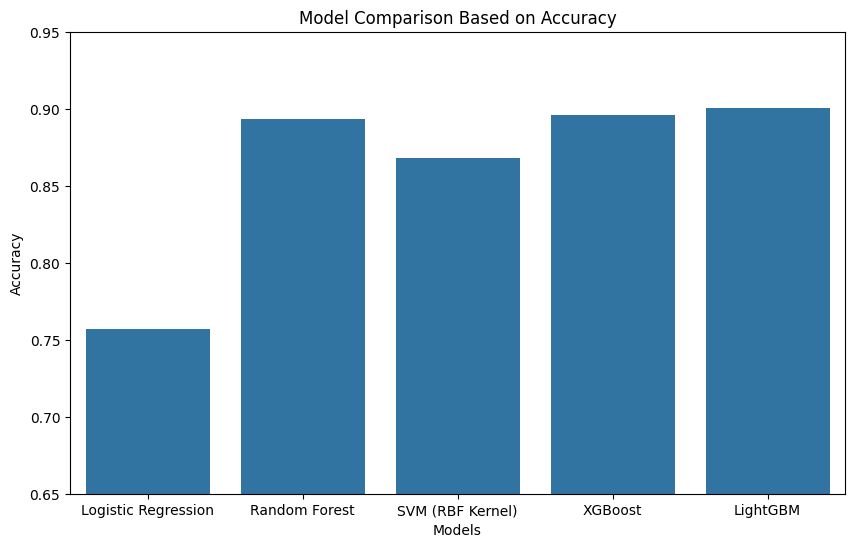

In [58]:
# Extract accuracy values from the results dictionary
accuracies = [metrics['accuracy'] for name, metrics in results.items()]
model_names = list(results.keys())  # Use actual model names

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Comparison Based on Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.65, 0.95)
plt.show()

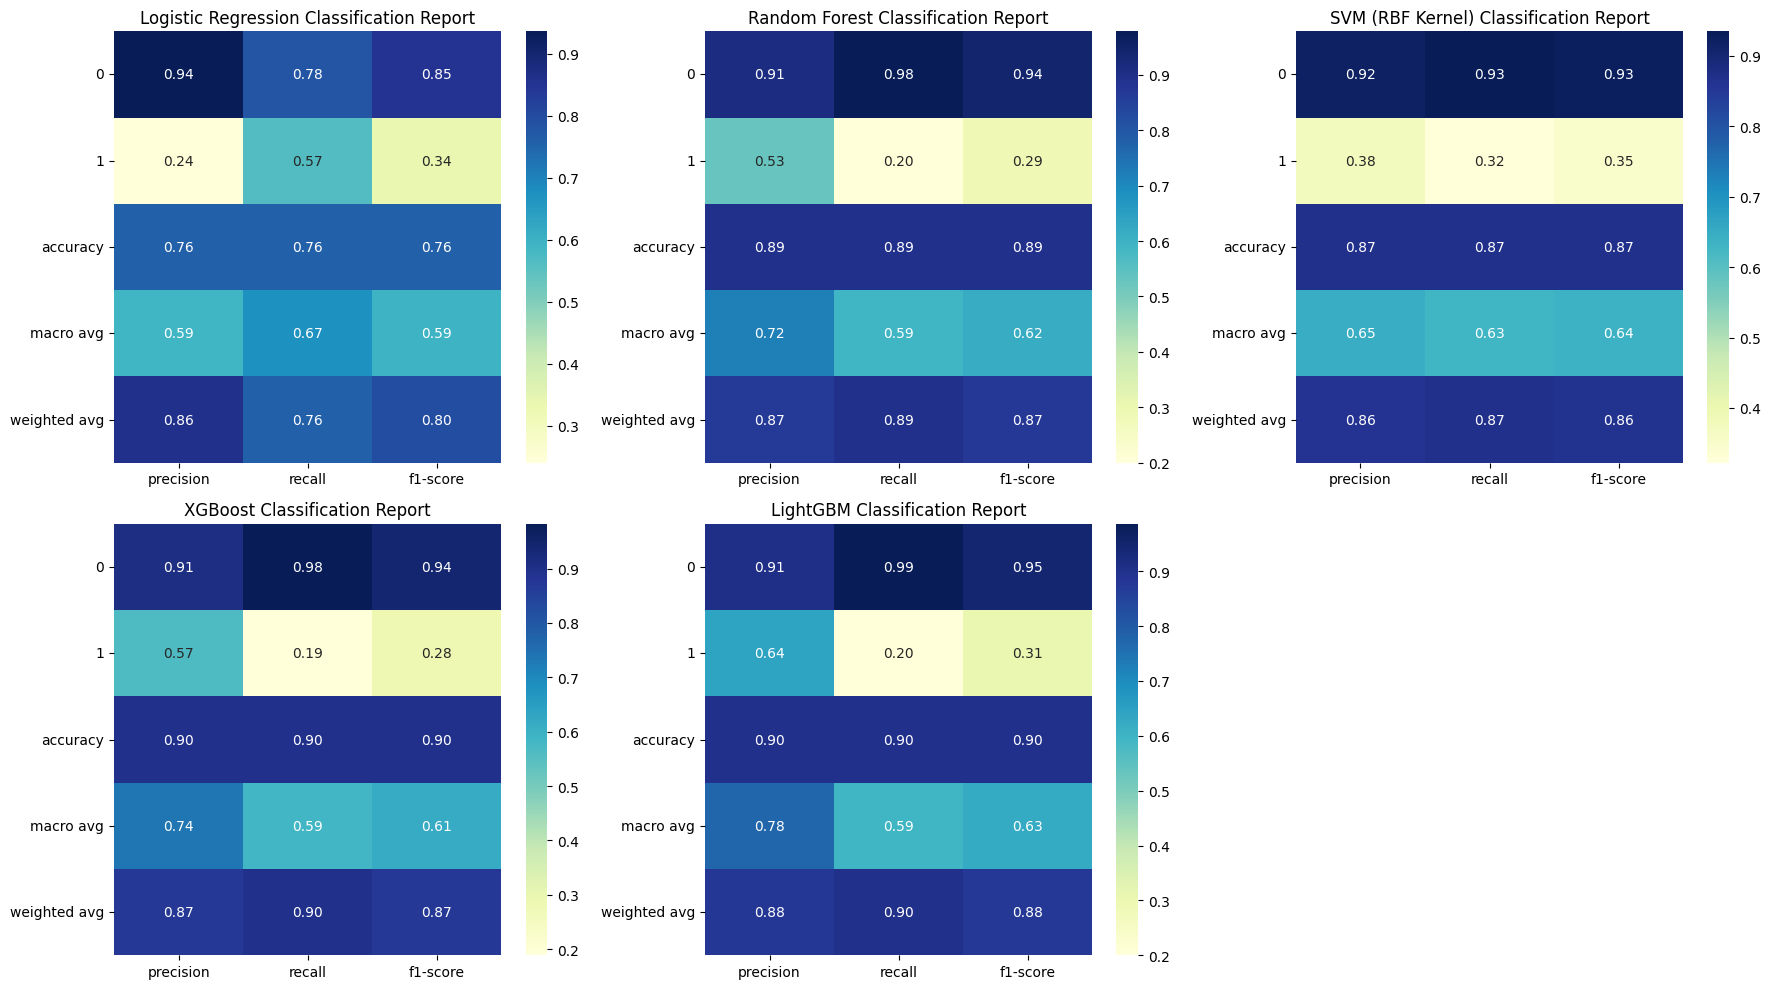

In [59]:
import math

# Total number of models
num_models = len(results)
cols = 3  # Number of columns in subplot grid
rows = math.ceil(num_models / cols)

plt.figure(figsize=(6 * cols, 5 * rows))

for idx, (name, metrics) in enumerate(results.items(), 1):
    y_pred = metrics['y_pred']
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row

    plt.subplot(rows, cols, idx)
    sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f'{name} Classification Report')

plt.tight_layout()
plt.show()


In [60]:
# Find the model with the best accuracy
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Best Params: {results[best_model_name]['best_params']}")


Best Model: LightGBM
Accuracy: 0.9005
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__n_estimators': 100, 'model__num_leaves': 31}


# 6. Deployment

In [61]:
#Saving the model
joblib.dump(model, "ada442_projectModel.pkl")

#Run the Streamlit interface and write this to terminal: streamlit run ada442_projectApp.py

['ada442_projectModel.pkl']